In [10]:
import asyncio
import itertools
import logging
import random
import nest_asyncio

nest_asyncio.apply()  # must be run at the start of every notebook to patch the event loop to allow nesting, eg. so we can run asyncio.run from within a notebook.

In [11]:
import os
from pathlib import Path
import tempfile

from shutil import rmtree
from typing import List, Optional, Union

In [12]:
# Adjust your env variables here if nescesary

%env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
%env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
%env NUPLAN_EXP_ROOT=../../data/nuplan/exp
%env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/
%pwd

env: NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
env: NUPLAN_MAPS_ROOT=../../data/nuplan/maps
env: NUPLAN_EXP_ROOT=../../data/nuplan/exp
env: NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/


'/home/ehdykhne/nuplan-devkit/experiments'

In [13]:
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

from nuplan.common.utils.s3_utils import is_s3_path
from nuplan.planning.script.builders.simulation_builder import build_simulations
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)
from nuplan.planning.script.utils import (
    run_runners,
    set_default_path,
    set_up_common_builder,
)
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# If set, use the env. variable to overwrite the default dataset and experiment paths
set_default_path()

# If set, use the env. variable to overwrite the Hydra config
CONFIG_PATH = os.getenv("NUPLAN_HYDRA_CONFIG_PATH", "config/simulation")

if os.environ.get("NUPLAN_HYDRA_CONFIG_PATH") is not None:
    CONFIG_PATH = os.path.join("../../../../", CONFIG_PATH)

if os.path.basename(CONFIG_PATH) != "simulation":
    CONFIG_PATH = os.path.join(CONFIG_PATH, "simulation")
CONFIG_NAME = "default_simulation"

In [14]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# Location of paths with all simulation configs
BASE_CONFIG_PATH = os.path.join(
    os.getenv("NUPLAN_TUTORIAL_PATH", ""), "../nuplan/planning/script"
)
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

# Create a temporary directory to store the simulation artifacts


scenario_types = [
    "accelerating_at_traffic_light_with_lead",
    "crossed_by_bike",
    "crossed_by_vehicle",
    # "on_intersection",
    # "on_stopline_crosswalk",
    # "on_stopline_stop_sign",
    # "on_stopline_traffic_light",
    "on_traffic_light_intersection",
    # "starting_protected_cross_turn",
    # "starting_protected_noncross_turn",
    # "starting_right_turn",
    "starting_straight_stop_sign_intersection_traversal",
    "starting_straight_traffic_light_intersection_traversal",
    # "starting_u_turn",
    "starting_unprotected_cross_turn",
    "starting_unprotected_noncross_turn",
    # "stationary_at_crosswalk",
    # "stationary_at_traffic_light_with_lead",
    # "stationary_at_traffic_light_without_lead",
    # "traversing_crosswalk",
    # "traversing_intersection",
    "traversing_traffic_light_intersection",
]

# scenario_types = ['stationary_at_traffic_light_without_lead']

scenario_builder = "val"  # [nuplan (uses trainval), nuplan_mini, test, val, train_boston, train_pittsburgh, train_singapore]
DATASET_PARAMS = [
    f"scenario_builder={scenario_builder}",
    "scenario_filter=all_scenarios",  # [all_scenarios, val14_split]
    f"scenario_filter.scenario_types={scenario_types}",  # there are 70 scenario types in the trainingset and 58 in the validation set including "unknown" which make up the majority
    # "scenario_filter.ego_displacement_minimum_m=10",  # use scenarios where the ego vehicle moves at least 10m
    #    'scenario_filter.remove_invalid_goals=true',  # remove scenarios where the goal is not invalid
    "scenario_filter.ego_start_speed_threshold=5",  # Exclusive threshold that the ego's speed must rise above (meters per second) for scenario to be kept
    #    'scenario_filter.stop_speed_threshold=10',  # Inclusive threshold that the ego's speed must fall below (meters per second) for scenario to be kept:
    "scenario_filter.map_names=[us-pa-pittsburgh-hazelwood]",  # [sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]
    # "scenario_filter.num_scenarios_per_type=200",  # use 10 scenarios per scenario type
    "scenario_filter.scenario_tokens=['df4441167a6f54f8']",  # List of scenarios to include (token)
    #    'scenario_filter.log_names=["2021.08.24.18.07.48_veh-45_01504_01722"]', # specific scenrios to simulate
    "scenario_filter.limit_total_scenarios=0.05",  # use n total scenarios if int, or if float smaller than 1, use n as a fraction of total scenarios (changes sampling frequency, unchanged leaves the frequency at 20Hz)
]
ckpt_dir = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt"
hybrid_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/pdm_offset_checkpoint.ckpt"
#'/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
#'/home/ehdykhne/Repos/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
print(simulation_hydra_paths.config_name)
cfg = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
        "model=urban_driver_open_loop_model",
        "planner=pdm_hybrid_planner",  # [ml_planner, pdm_hybrid_planner, gc_pgp_planner, idm_planner, log_future_planner, simple_planner]
        f"planner.pdm_hybrid_planner.checkpoint_path={hybrid_ckpt}",
        "observation.model_config=${model}",
        f"observation.checkpoint_path={ckpt_dir}",
        f"observation.planner_type=pdm_hybrid",
        f"observation.pdm_hybrid_ckpt={hybrid_ckpt}",
        f"observation.occlusions=true",
        "+occlusion=true",
        "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
        "+occlusion.uncloak_reaction_time=1.5",
        "+occlusion.notice_threshold=1.0",
        "worker=ray_distributed",  # [sequential, ray_distributed]
        "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
        *DATASET_PARAMS,
    ],
)

output_folder = cfg.output_dir
print('output_folder = "' + output_folder + '"')


# "+simulation=open_loop_boxes",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
#         #'model=gc_pgp_model',
#         #'model.aggregator.pre_train=false',
#         # 'planner=pdm_hybrid_planner',
#         # f"planner.pdm_hybrid_planner.checkpoint_path={ckpt_dir}" ,
#         "planner=log_future_planner",  # [ml_planner, pdm_hybrid_planner, gc_pgp_planner, idm_planner, log_future_planner, simple_planner]
#         #'model=urban_driver_open_loop_model',
#         "ego_controller=perfect_tracking_controller",
#         #'planner.ml_planner.model_config=${model}',
#         # f'planner.ml_planner.checkpoint_path={obs_ckpt_dir}',
#         # f'observation=idm_agents_observation',
#         #'observation.model_config=${model}',
#         # f'observation.checkpoint_path={ckpt_dir}',
#         "worker=ray_distributed",  # [sequential, ray_distributed]
#         "+occlusion=true",  # [true, false]
#         "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
#         "+occlusion.uncloak_reaction_time=1.5",
#         "+occlusion.notice_threshold=1.0",
#         # "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
#         *DATASET_PARAMS,


# output folders for runs:
# closed_loop_reactive_agents, wedge occlusions, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.21.59.48"
# overall score: 0.5041, ego_at_fault_collisions: 363

# closed_loop_reactive_agents, occlusions = False, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.23.21.13"
# overall score: 0.5041, ego_at_fault_collisions: 357

# closed_loop_nonreactive_agents, occlusions = False, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.02.01.14"
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.07.32.41"
# overall score: , ego_at_fault_collisions:

# closed_loop_nonreactive_agents, wedge occlusions, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.08.29.23"
# overall score: , ego_at_fault_collisions:

# closed_loop_reactive_agents, wedge occlusions, gc_pgp
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.10.09.31.44"
# overall score: , ego_at_fault_collisions:

# 'closed_loop_reactive_agents, occlusions = False, gc_pgp'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.11.00.41.30"

# 'closed_loop_reactive_agents, occlusions = False, pdm_hybrid'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.12.21.28"

# 'closed_loop_reactive_agents,  wedge occlusions, pdm_hybrid'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.13.07.48"

default_simulation


output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2023.12.31.07.38.41"


# Now we can run with the following

Global seed set to 0


2023-12-31 07:38:41,901 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:20}  Building MultiMainCallback...
2023-12-31 07:38:41,920 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:35}  Building MultiMainCallback: 4...DONE!
2023-12-31 07:38:42,078 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-12-31 07:38:42,079 WARNING {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:135}  Ray is running, we will shut it down before starting again!
2023-12-31 07:38:44,697 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2023-12-31 07:38:46,315	INFO worker.py:1636 -- Started a local Ray instance.


2023-12-31 07:38:46,954 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2023-12-31 07:38:46,955 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 4
Number of threads across all nodes: 32
2023-12-31 07:38:46,955 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2023-12-31 07:38:46,955 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2023-12-31 07:38:46,955 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2023.12.31.07.38.41

2023-12-31 07:38:46,956 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_build

Ray objects: 100%|██████████| 32/32 [00:01<00:00, 26.39it/s]


2023-12-31 07:38:48,231 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:76}  Building metric engines...
2023-12-31 07:38:48,248 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:78}  Building metric engines...DONE
2023-12-31 07:38:48,248 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:82}  Building simulations from 1 scenarios...
2023-12-31 07:38:48,346 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:18}  Building TorchModuleWrapper...
2023-12-31 07:38:48,368 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/model_builder.py:21}  Building TorchModuleWrapper...DONE!
2023-12-31 07:38:48,673 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:142}  Building simulations...DONE!
2023-12-31 07:38:48,674 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:114}  

Ray objects:   0%|          | 0/1 [00:00<?, ?it/s]

(wrapped_fn pid=742868) 1629836925299404
(wrapped_fn pid=742868) 1629836925399402
(wrapped_fn pid=742868) 1629836925499433
(wrapped_fn pid=742868) 1629836925599489
(wrapped_fn pid=742868) 1629836925699559
(wrapped_fn pid=742868) 1629836925799640
(wrapped_fn pid=742868) 1629836925899722
(wrapped_fn pid=742868) 1629836925999797
(wrapped_fn pid=742868) 1629836926099864
(wrapped_fn pid=742868) 1629836926199925
(wrapped_fn pid=742868) 1629836926299990
(wrapped_fn pid=742868) 1629836926400063
(wrapped_fn pid=742868) 1629836926500134
(wrapped_fn pid=742868) 1629836926600200
(wrapped_fn pid=742868) 1629836926700265
(wrapped_fn pid=742868) 1629836926800333
(wrapped_fn pid=742868) 1629836926900403
(wrapped_fn pid=742868) 1629836927000470
(wrapped_fn pid=742868) 1629836927100522
(wrapped_fn pid=742868) 1629836927200553
(wrapped_fn pid=742868) 1629836927300569
(wrapped_fn pid=742868) 1629836927400562
(wrapped_fn pid=742868) 1629836927500525
(wrapped_fn pid=742868) 1629836925299404
(wrapped_fn pid=

Ray objects: 100%|██████████| 1/1 [06:29<00:00, 389.20s/it]


2023-12-31 07:45:17,909 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:127}  Number of successful simulations: 1
2023-12-31 07:45:17,910 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:128}  Number of failed simulations: 0
2023-12-31 07:45:17,910 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2023-12-31 07:45:17,913 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2023.12.31.07.38.41/runner_report.parquet
2023-12-31 07:45:17,913 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:06:35 [HH:MM:SS]
2023-12-31 07:45:17,963 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:79}  Metric files integration: 00:00:00 [HH:MM:SS]
2023-12-31 07:45:18,013 I

Rendering histograms:   5%|▍         | 1/21 [00:00<00:03,  5.80it/s]

2023-12-31 07:45:18,136 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-12-31 07:45:18,138 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Rendering histograms:  24%|██▍       | 5/21 [00:00<00:01, 13.43it/s]

2023-12-31 07:45:18,341 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-12-31 07:45:18,343 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-12-31 07:45:18,347 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-12-31 07:45:18,348 INFO {/home/ehdykhne/miniconda3

Rendering histograms: 100%|██████████| 21/21 [00:02<00:00,  8.85it/s]


2023-12-31 07:45:22,689 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:04 [HH:MM:SS]
2023-12-31 07:45:22,689 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:116}  Finished running simulation!


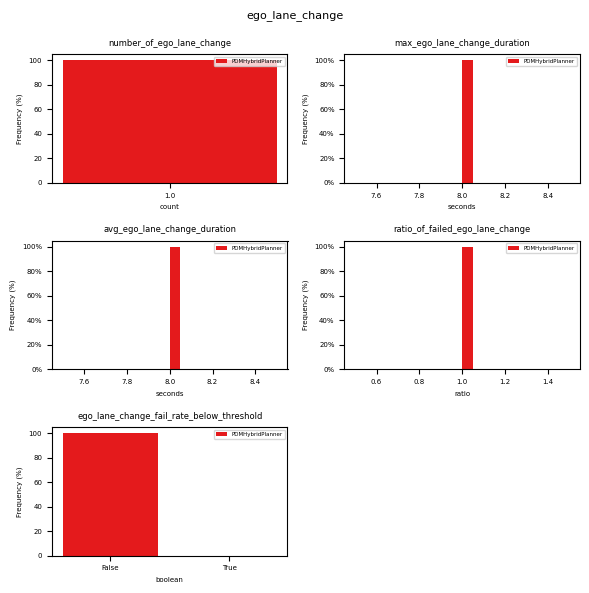

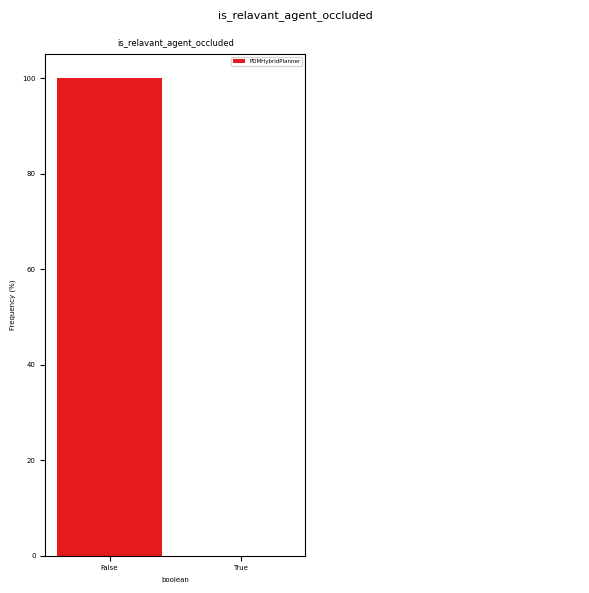

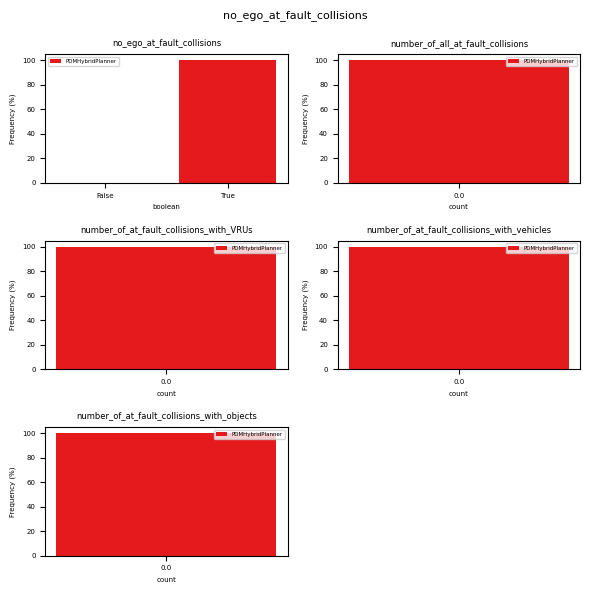

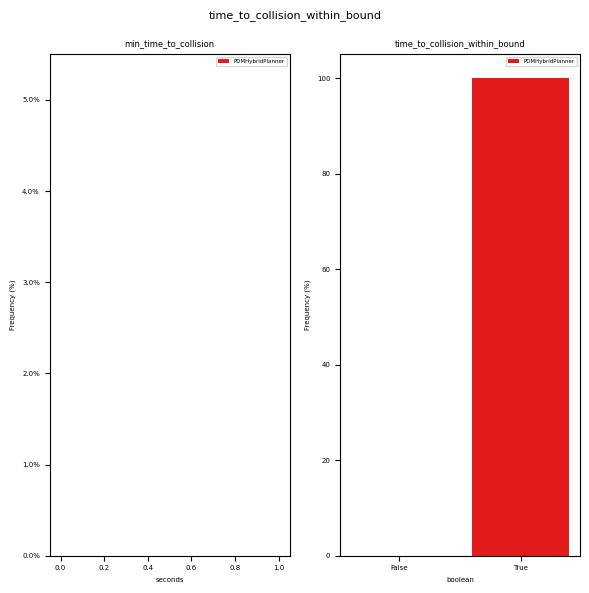

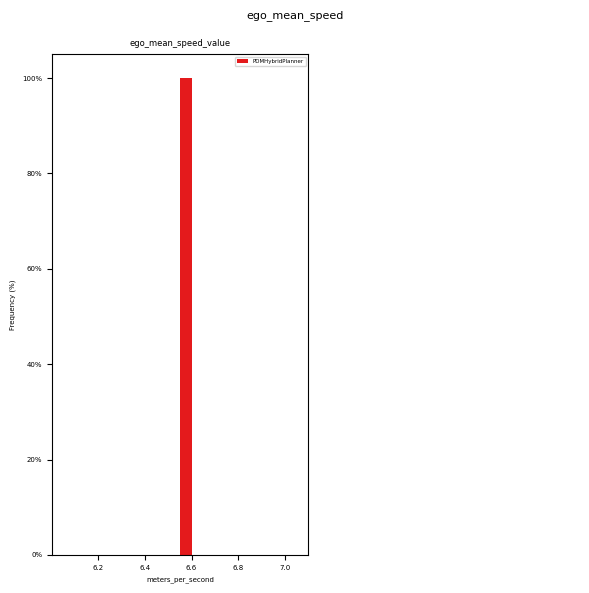

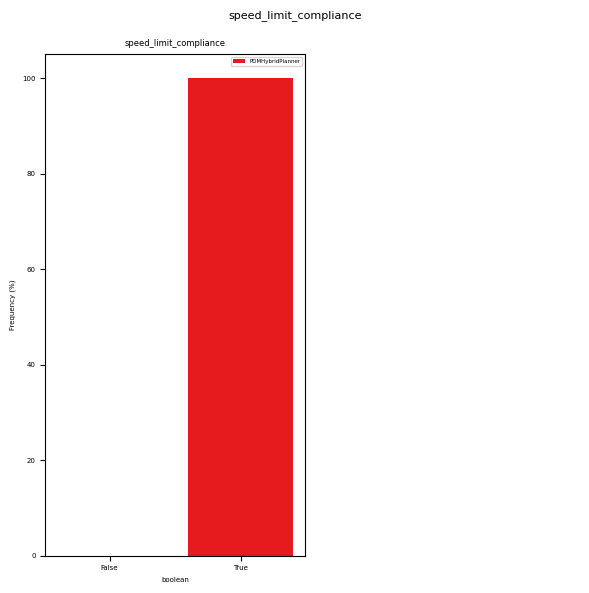

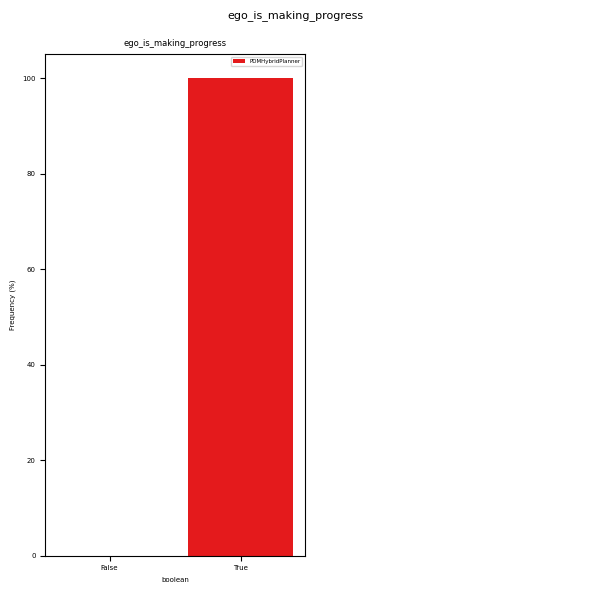

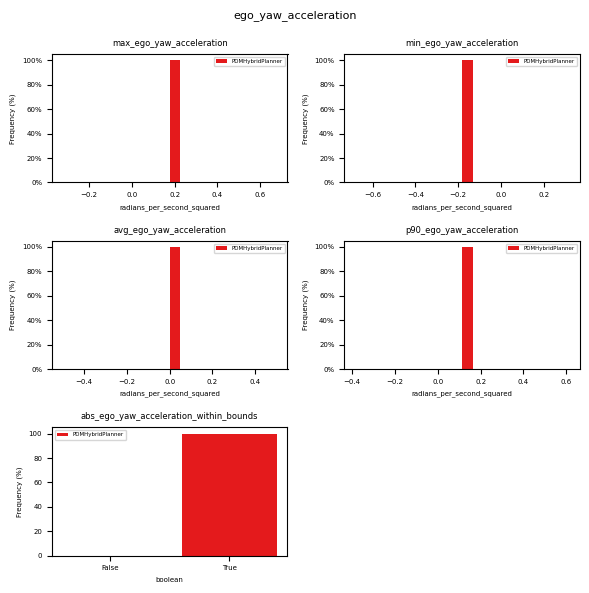

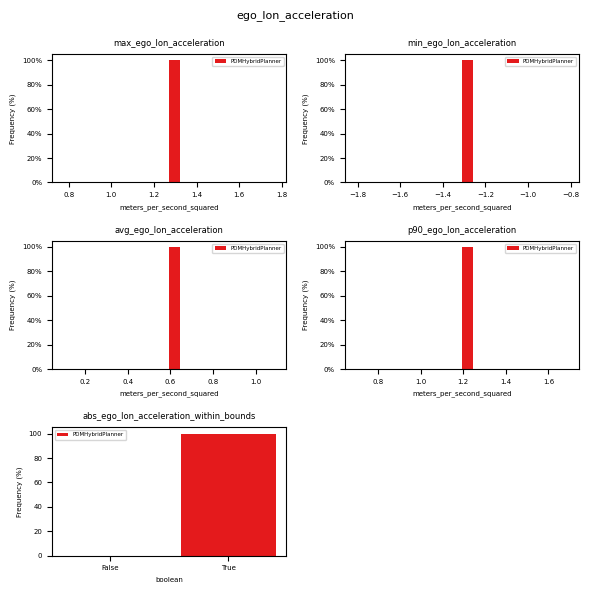

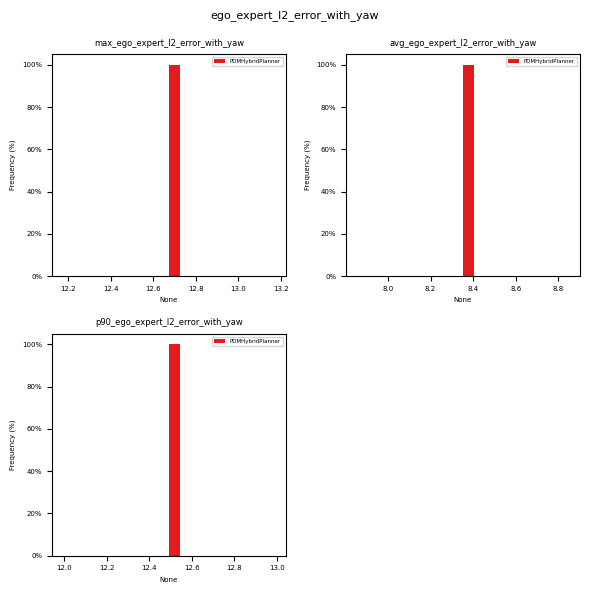

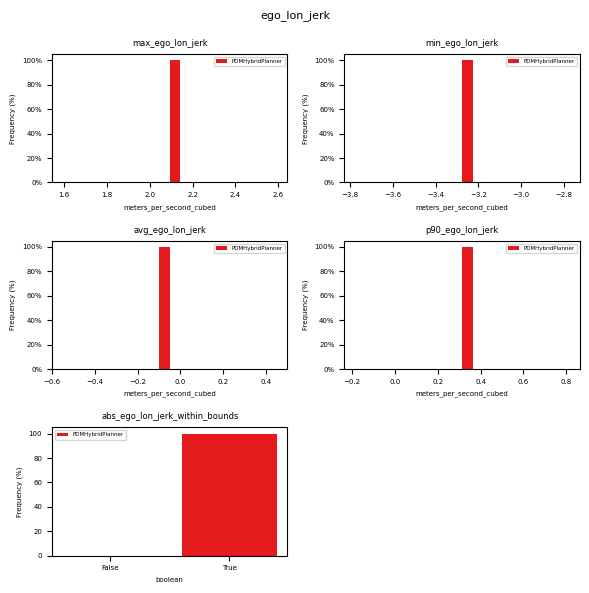

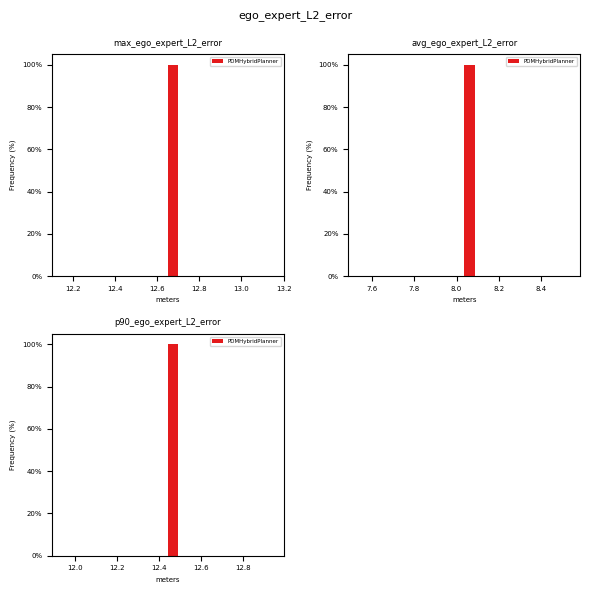

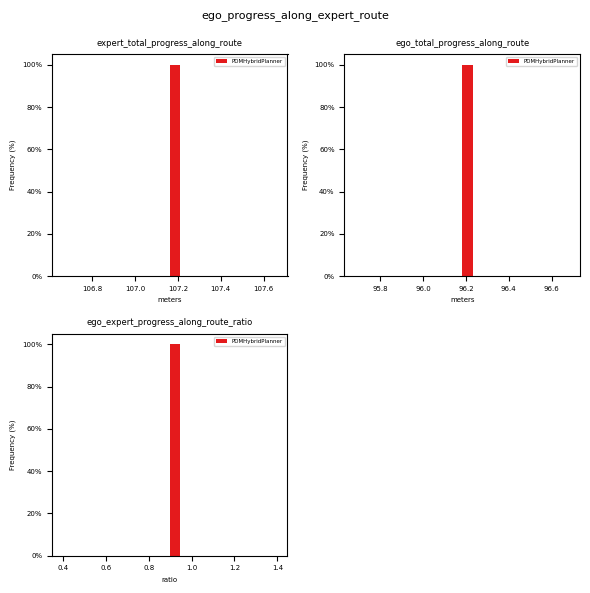

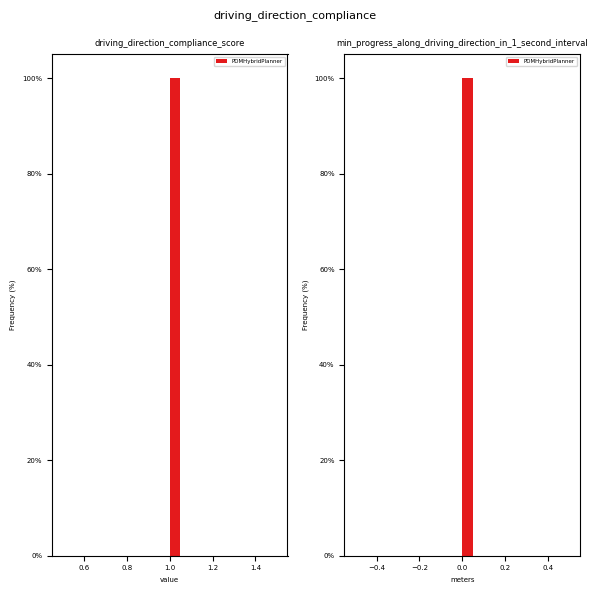

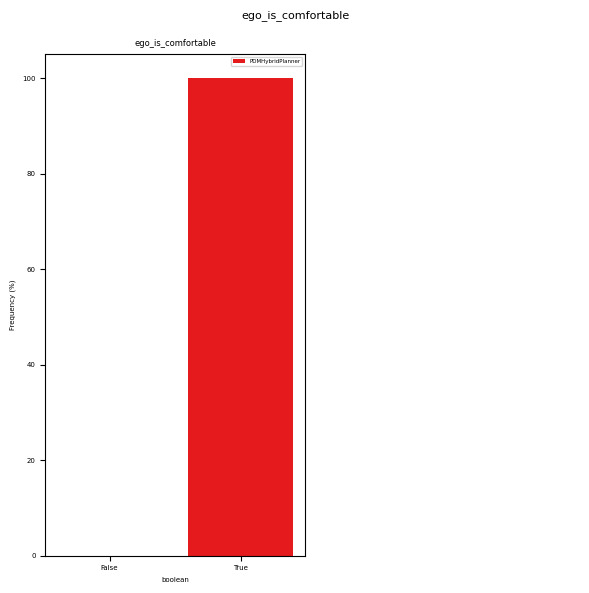

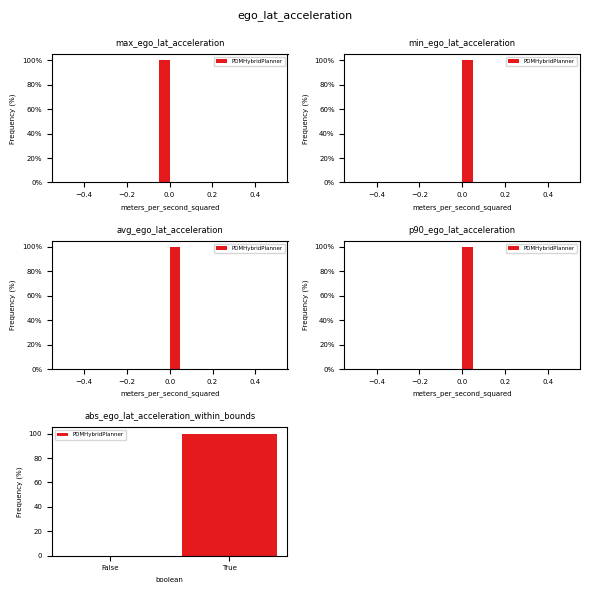

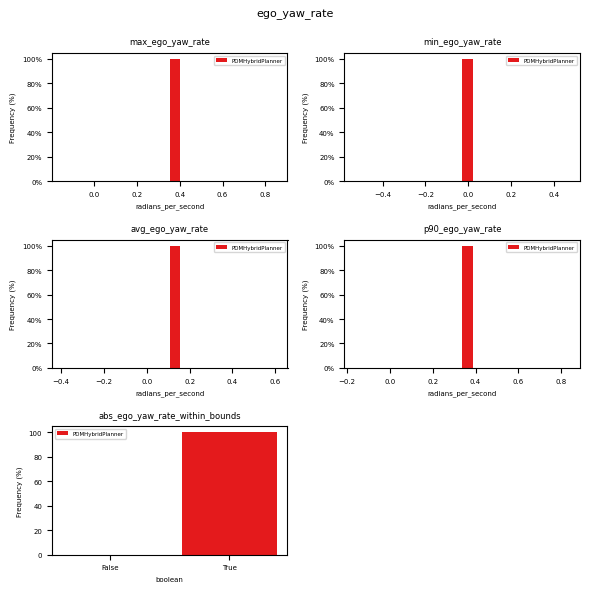

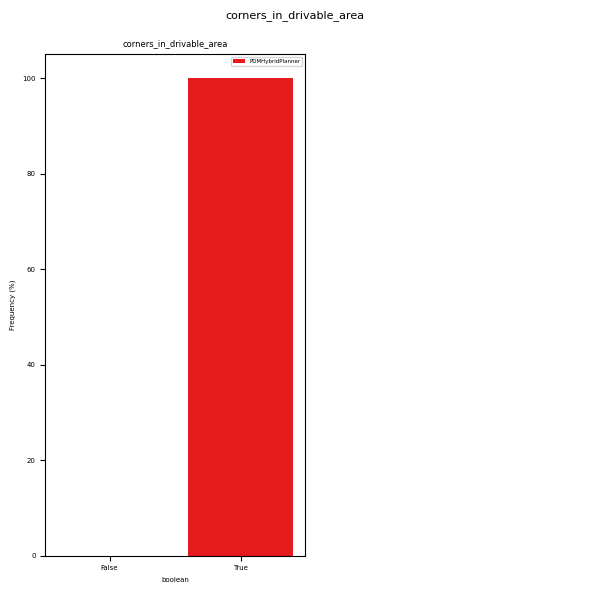

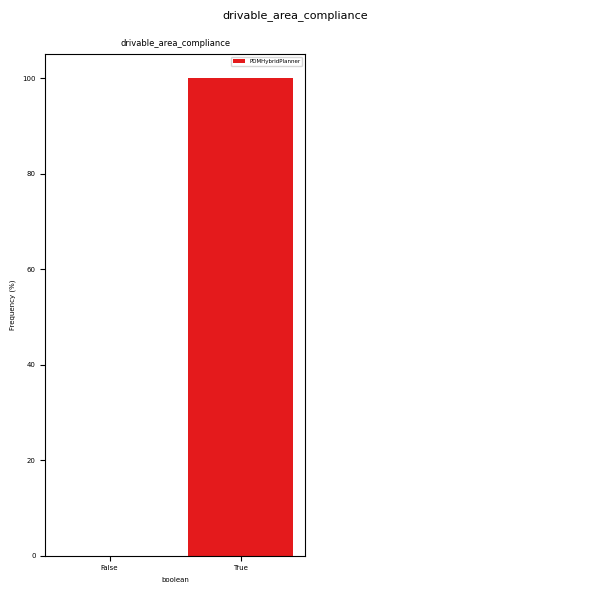

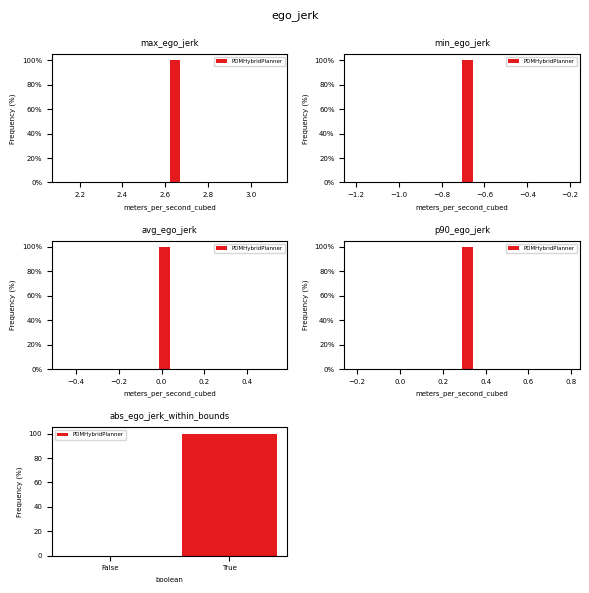

In [15]:
from nuplan.planning.script.run_simulation import main as main_simulation

# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg)

## Prepare the nuBoard config

In [16]:
output_folder_alt = []
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.21.59.48"
)
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.23.21.13"
)
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.07.32.41"
)
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.08.29.23"
)
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.11.00.41.30"
)
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.10.09.31.44"
)
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.12.21.28"
)
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.13.07.48"
)

In [17]:
# scenario_builder = "val"  # [nuplan (uses trainval), nuplan_mini, test, val, train_boston, train_pittsburgh, train_singapore]
# output_folder = "../../data/nuplan/exp/exp/simulation/open_loop_boxes/2023.12.31.02.58.31"
# output_folder = (
#     "../../data/nuplan/exp/exp/simulation/open_loop_boxes/2023.12.20.13.59.34"
# )
# output_folder = '../../data/nuplan/exp/exp/simulation/open_loop_boxes/2023.12.09.21.19.06'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.21.59.48"
# Location of path with all nuBoard configs
CONFIG_PATH = "../nuplan/planning/script/config/nuboard"
CONFIG_NAME = "default_nuboard"

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(
    config_name=CONFIG_NAME,
    overrides=[
        f"scenario_builder={scenario_builder}",  # set the database (same as simulation) used to fetch data for visualization
        f"simulation_path={output_folder}",  # [output_folder, output_folder_alt] nuboard file path(s), if left empty the user can open the file inside nuBoard
    ],
)

## Launch nuBoard (open in new tab - recommended)

In [18]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

2023-12-31 07:45:27,453 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2023-12-31 07:45:27,472 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2023-12-31 07:45:27,477 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2023-12-31 07:45:27,477 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:85}  Async rendering is set to: True
2023-12-31 07:45:27,477 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/server.py:403}  Starting Bokeh server version 2.4.3 (running on Tornado 6.3.3)
2023-12-31 07:45:27,478 WARNING {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/util.py:145}  Host wildcard '*' will allow connections originating from multiple (or possib

INFO:tornado.access:200 GET / (127.0.0.1) 213.59ms
INFO:tornado.access:101 GET /ws (127.0.0.1) 0.45ms


2023-12-31 07:45:29,227 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  101 GET /ws (127.0.0.1) 0.45ms
2023-12-31 07:45:29,228 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:132}  WebSocket connection opened
2023-12-31 07:45:29,228 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:213}  ServerConnection created
2023-12-31 07:45:29,684 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2023-12-31 07:45:29,689 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0004 seconds.
2023-12-31 07:45:29,779 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET / (127.0.0.1) 199.90ms


INFO:tornado.access:200 GET / (127.0.0.1) 199.90ms
Rendering a scenario: 100%|██████████| 1/1 [00:00<00:00, 31.57it/s]


2023-12-31 08:06:29,835 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 2.9591 seconds.
